In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *
from tqdm import tqdm

In [3]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2]) 
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([]) 

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True, 
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, spk2_rec.shape[-1]])

  plt.show()

In [4]:
# NOTE volterra signals 

num_steps = 1000
num_inputs = 20

volterra_path = "/home/ruomin_zhu/l2l_data/volterra_data/"

waves = torch.zeros(num_steps, num_inputs)
picks = torch.randperm(100)
for i in range(num_inputs):
    temp = pkl_load(volterra_path+f"pair_{picks[i]}.pkl")[1,500:500+num_steps]
    # waves[:,i] = (temp - temp.min()) / (temp.max() - temp.min())
    waves[:,i] = temp

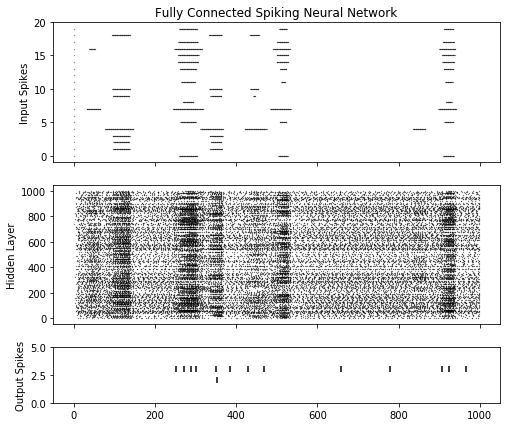

In [16]:
spk_in = spikegen.delta(waves, threshold = 0.01, off_spike = True).unsqueeze(1)

num_hidden = 1000
num_outputs = 5
beta = 0.99
# alpha = 0.7
# beta = 0.5
# threshold = 2

# initialize layers
fc1 = nn.Linear(num_inputs, num_hidden)
# lif1 = snn.Synaptic(alpha=alpha, beta=beta, threshold = threshold)
lif1 = snn.Leaky(beta=beta, threshold = 2)
fc2 = nn.Linear(num_hidden, num_outputs)
# lif2 = snn.Synaptic(alpha=alpha, beta=beta, threshold = 1.5 * threshold)
lif2 = snn.Leaky(beta=beta, threshold = 2)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()
# syn1, mem1 = lif1.init_synaptic()
# syn2, mem2 = lif1.init_synaptic()

# record outputs
mem2_rec = []
spk1_rec = []
spk2_rec = []

# network simulation
for step in range(num_steps):
    cur1 = fc1(spk_in[step])
    spk1, mem1 = lif1(cur1, mem1)
    # spk1, syn1, mem1 = lif1(cur1, syn1, mem1) 
    cur2 = fc2(spk1)
    spk2, mem2 = lif2(cur2, mem2)
    # spk2, syn2, mem2 = lif2(cur2, syn2, mem2)

    mem2_rec.append(mem2)
    spk1_rec.append(spk1)
    spk2_rec.append(spk2)

# convert lists to tensors
mem2_rec = torch.stack(mem2_rec)
spk1_rec = torch.stack(spk1_rec)
spk2_rec = torch.stack(spk2_rec)

plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

In [17]:
fc1 = nn.Linear(num_inputs, num_hidden)
# lif1 = snn.Synaptic(alpha=alpha, beta=beta, threshold = threshold)
lif1 = snn.Leaky(beta=beta, threshold = 2)
fc2 = nn.Linear(num_hidden, num_outputs)
# lif2 = snn.Synaptic(alpha=alpha, beta=beta, threshold = 1.5 * threshold)
lif2 = snn.Leaky(beta=beta, threshold = 2)

# Initialize hidden states
mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

In [26]:
fc1._parameters["bias"].shape

torch.Size([1000])

In [6]:
num_steps     = 1000
num_inputs    = 20
volterra_path = "/home/ruomin_zhu/l2l_data/volterra_data/"
data_path     = "/home/ruomin_zhu/l2l_data/snn_data_new/"

picks = torch.randperm(100)

waves = torch.zeros(num_steps, num_inputs)
for i in range(num_inputs):
    temp = pkl_load(volterra_path+f"pair_{picks[i]}.pkl")[1,500:500+num_steps]
    # waves[:,i] = (temp - temp.min()) / (temp.max() - temp.min())
    waves[:,i] = temp
spk_in = spikegen.delta(waves, threshold = 0.01, off_spike = True).unsqueeze(1)


for idx in tqdm(range(100)):
    num_hidden = 1000
    num_outputs = 5
    beta = 0.99
    # alpha = 0.7
    # beta = 0.5
    threshold = 2

    # initialize layers
    fc1 = nn.Linear(num_inputs, num_hidden)
    # lif1 = snn.Synaptic(alpha=alpha, beta=beta, threshold = threshold)
    lif1 = snn.Leaky(beta=beta, threshold = threshold)
    fc2 = nn.Linear(num_hidden, num_outputs)
    # lif2 = snn.Synaptic(alpha=alpha, beta=beta, threshold = 1.5 * threshold)
    lif2 = snn.Leaky(beta=beta, threshold = threshold)

    # Initialize hidden states
    mem1 = lif1.init_leaky()
    mem2 = lif2.init_leaky()
    # syn1, mem1 = lif1.init_synaptic()
    # syn2, mem2 = lif1.init_synaptic()

    # record outputs
    mem2_rec = []
    spk1_rec = []
    spk2_rec = []

    # network simulation
    for step in range(num_steps):
        cur1 = fc1(spk_in[step])
        spk1, mem1 = lif1(cur1, mem1)
        # spk1, syn1, mem1 = lif1(cur1, syn1, mem1) 
        cur2 = fc2(spk1)
        spk2, mem2 = lif2(cur2, mem2)
        # spk2, syn2, mem2 = lif2(cur2, syn2, mem2)

        mem2_rec.append(mem2)
        spk1_rec.append(spk1)
        spk2_rec.append(spk2)

    # convert lists to tensors
    mem2_rec = torch.stack(mem2_rec)
    spk1_rec = torch.stack(spk1_rec)
    spk2_rec = torch.stack(spk2_rec)
    
    snn_data = {
        "waves": waves,
        "mems" : mem2_rec.detach().squeeze(),
        }
    pkl_save(snn_data, data_path+f"snn_mem_{idx}.pkl")
    # break

100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


In [18]:
snn_data = {
    "waves": waves,
    "mems" : mem2_rec.detach(),
    }

In [28]:
data1 = pkl_load("/home/ruomin_zhu/l2l_data/snn_data_new/snn_mem_0.pkl")

In [30]:
data2 = pkl_load("/home/ruomin_zhu/l2l_data/snn_data_new/snn_mem_1.pkl")

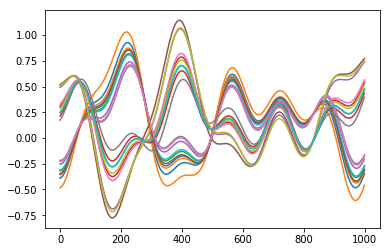

In [31]:
plt.plot(data2["waves"])